# Diabetic Retinopathy

### Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
import plotly
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from plotly.offline import iplot, init_notebook_mode
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.4.0


In [5]:
os.listdir("./train")

['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

In [7]:
os.listdir(os.path.join("train", "Mild"))

['0024cdab0c1e.png',
 '00cb6555d108.png',
 '0124dffecf29.png',
 '01b3aed3ed4c.png',
 '0369f3efe69b.png',
 '03e25101e8e8.png',
 '04ac765f91a1.png',
 '059bc89df7f4.png',
 '05a5183c92d0.png',
 '0684311afdfc.png',
 '06b71823f9cd.png',
 '07929d32b5b3.png',
 '07a1c7073982.png',
 '086d41d17da8.png',
 '09935d72892b.png',
 '0a3202889f4d.png',
 '0a61bddab956.png',
 '0ad7f631dedb.png',
 '0d310aba6373.png',
 '0dc031c94225.png',
 '0dce95217626.png',
 '0eb52045349f.png',
 '0f495d87656a.png',
 '0fb1053285cf.png',
 '101b9ebfc720.png',
 '107aea0d9289.png',
 '10f36b0239fb.png',
 '1116271db4ea.png',
 '111898ab463d.png',
 '12ce6a1a1f31.png',
 '12e3f5f2cb17.png',
 '13ab8db8c700.png',
 '15cc2aef772a.png',
 '172df1330a60.png',
 '17eff993386f.png',
 '18b06f56ab27.png',
 '194814669fee.png',
 '19722bff5a09.png',
 '19e350c7c83c.png',
 '1a03a7970337.png',
 '1b329a127307.png',
 '1bb0ddfe753a.png',
 '1c0cf251b426.png',
 '1c3a6b4449e9.png',
 '1d11794057ff.png',
 '1d674e2e32e0.png',
 '1df3e03a8f5f.png',
 '1e8a1fdee5b

In [8]:
# Check the number of images in the dataset
train = []
label = []

# os.listdir returns image class names
for i in os.listdir("./train"):
    train_class = os.listdir(os.path.join("train", i))
    for j in train_class:
        img = os.path.join('train',i,j)
        train.append(img)
        label.append(i)
        
print("Number of train images :",len(train))

Number of train images : 3662


### Explolatory Data Analysis

In [19]:
# Check the number of images in each class in the training dataset

No_images_per_class = []
Class_name = []
for i in os.listdir('./train'):
  train_class = os.listdir(os.path.join('train', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in Mild = 370 

Number of images in Moderate = 999 

Number of images in No_DR = 1805 

Number of images in Proliferate_DR = 295 

Number of images in Severe = 193 



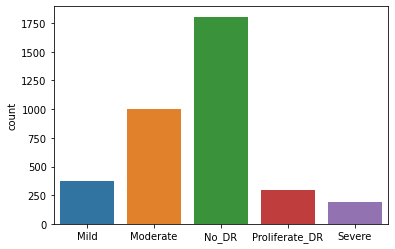

In [17]:
# Visualize how the Dataset is Distributed

sns.countplot(label);

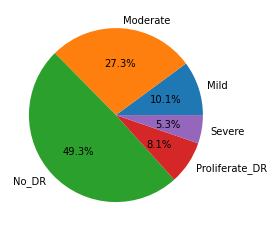

In [23]:
fig1, ax1 = plt.subplots()
ax1.pie(No_images_per_class, labels = Class_name, autopct = '%1.1f%%')
plt.show;

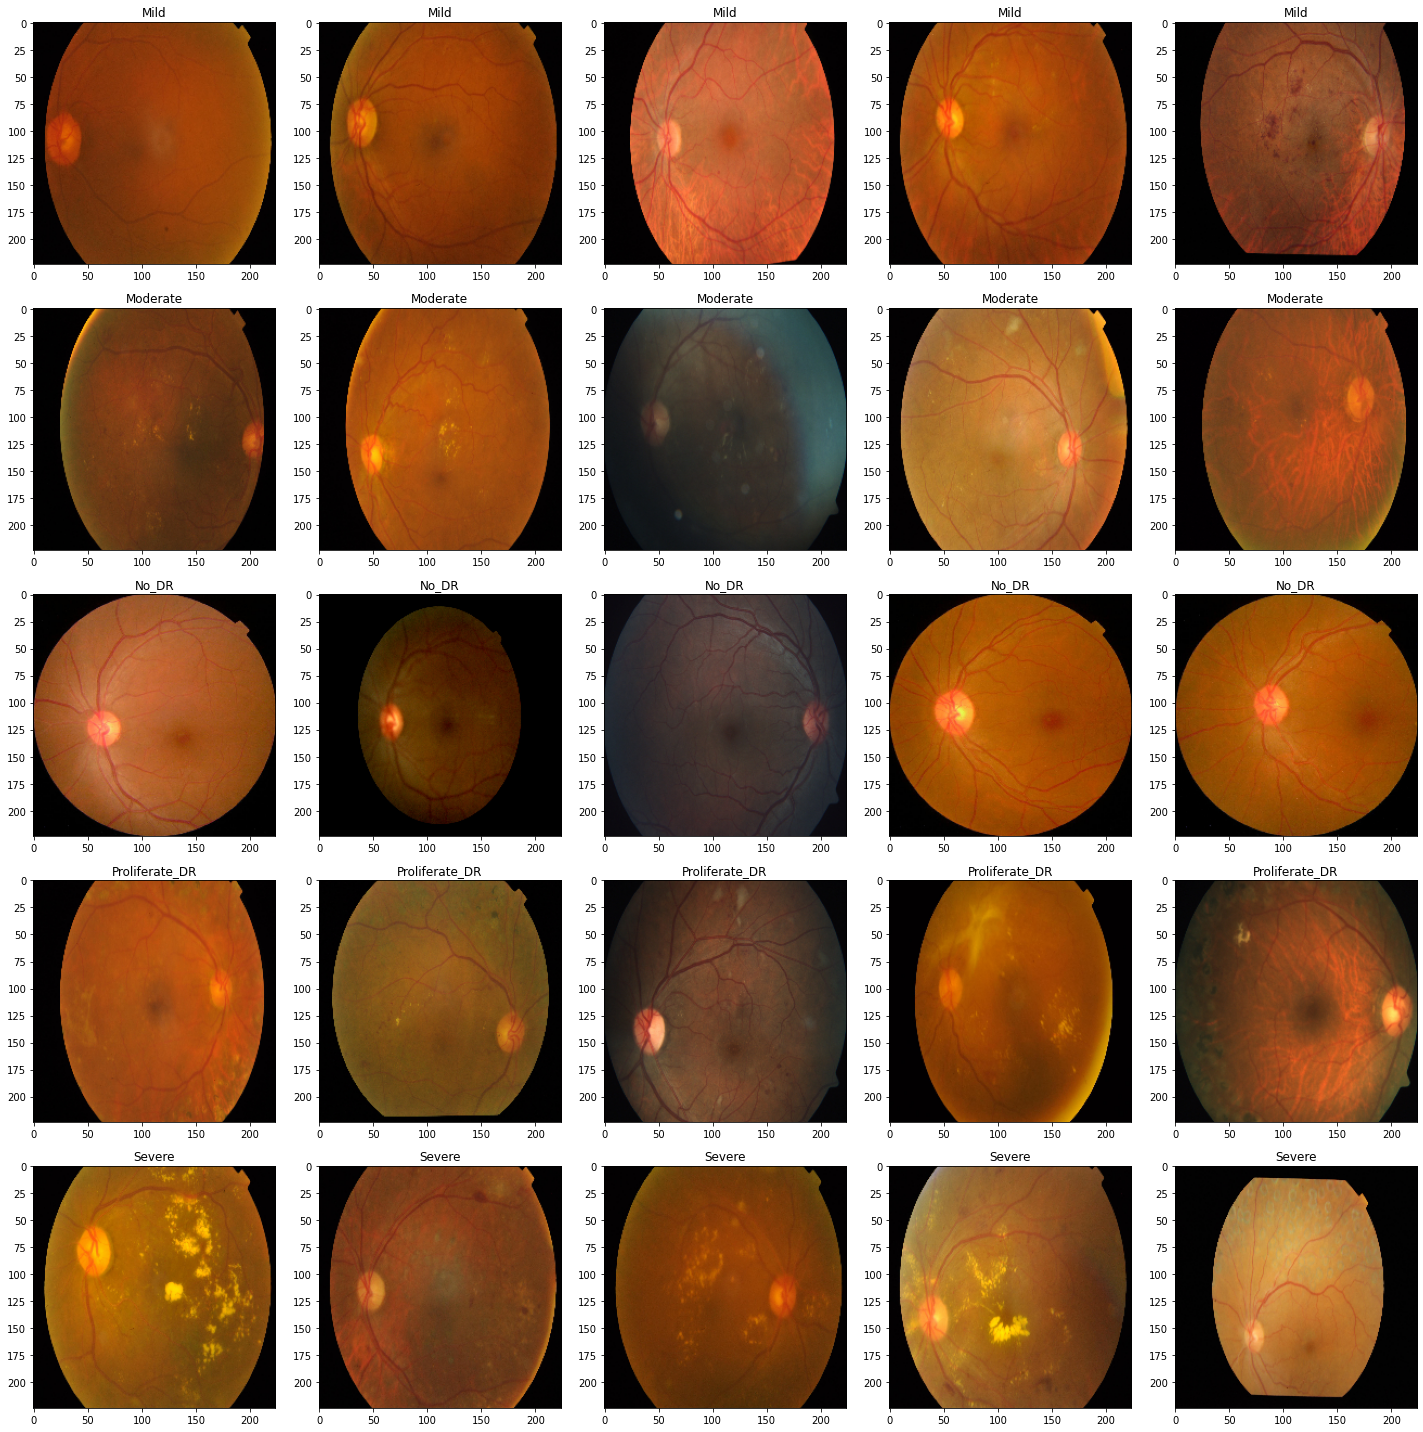

In [18]:
# Visualize 5 images for each class in the dataset

fig, axs = plt.subplots(5, 5, figsize = (20, 20))
count = 0
for i in os.listdir('./train'):
  # Get the list of images in a given class
  train_class = os.listdir(os.path.join('train', i))
  # Plot 5 images per class
  for j in range(5):
    img = os.path.join('train', i, train_class[j])
    img = PIL.Image.open(img)
    axs[count][j].title.set_text(i)
    axs[count][j].imshow(img)  
  count += 1

fig.tight_layout()

In [25]:
# Creating the Pandas Data Frame

retina_df = pd.DataFrame({'Image': train,'Labels': label})
retina_df.head()

Image Labels
0  train\Mild\0024cdab0c1e.png   Mild
1  train\Mild\00cb6555d108.png   Mild
2  train\Mild\0124dffecf29.png   Mild
3  train\Mild\01b3aed3ed4c.png   Mild
4  train\Mild\0369f3efe69b.png   Mild

### Data Augmentation

In [26]:
# Shuffle the data and split it into training and testing

retina_df = shuffle(retina_df)
train, test= train_test_split(retina_df, test_size = 0.2)

In [28]:
# Create run-time augmentation on training and test dataset
# For training datagenerator, add normalization, shear angle, zooming range and horizontal flip

train_datagen = ImageDataGenerator(
        rescale = 1./255,
        shear_range = 0.2,
        validation_split = 0.15)

# For test datagenerator, we only normalize the data.
test_datagen = ImageDataGenerator(rescale = 1./255)

In [29]:
# Creating datagenerator for training, validation and test dataset.

train_generator = train_datagen.flow_from_dataframe(
    train,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    subset='training')

validation_generator = train_datagen.flow_from_dataframe(
    train,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    subset='validation')

test_generator = test_datagen.flow_from_dataframe(
    test,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32)

Found 2490 validated image filenames belonging to 5 classes.
Found 439 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.


### Build the Model using ResNet

In [30]:
def res_block(X, filter, stage):
  
  # =========================================
  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter
    
  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # =========================================
  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # =========================================  
  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [31]:
input_shape = (256,256,3)

#Input tensor shape
X_input = Input(input_shape)

#Zero-padding

X = ZeroPadding2D((3,3))(X_input)

# 1 - stage

X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2- stage

X = res_block(X, filter= [64,64,256], stage= 2)

# 3- stage

X = res_block(X, filter= [128,128,512], stage= 3)

# 4- stage

X = res_block(X, filter= [256,256,1024], stage= 4)

# # 5- stage

# X = res_block(X, filter= [512,512,2048], stage= 5)

# Average Pooling

X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer

X = Flatten()(X)
X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)


model = Model( inputs= X_input, outputs = X, name = 'Resnet18')

model.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

### Training the Model

In [32]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])


In [33]:
#using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

#save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

In [36]:
history = model.fit(train_generator, steps_per_epoch = train_generator.n // 32, epochs = 1, validation_data= validation_generator, validation_steps= validation_generator.n // 32, callbacks=[checkpointer , earlystopping])

77/77 [==============================] - 521s 7s/step - loss: 0.6643 - accuracy: 0.7608 - val_loss: 0.9113 - val_accuracy: 0.6370

Epoch 00001: val_loss improved from 1.36033 to 0.91130, saving model to weights.hdf5


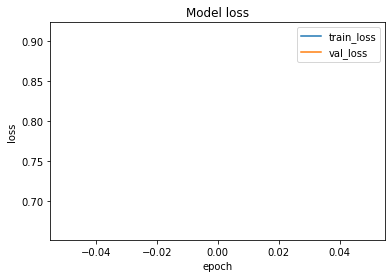

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()


### Model Assessment

In [46]:
# Loaded a modeltrained for 8+ hours,which yielded best accracy

model.load_weights("retina_weights.hdf5")

In [39]:
# Evaluate the performance of the model
evaluate = model.evaluate(test_generator, steps = test_generator.n // 32, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

22/22 [==============================] - 24s 1s/step - loss: 0.5270 - accuracy: 0.8082
Accuracy Test : 0.8082386255264282


In [47]:
# Assigning label names to the corresponding indexes
labels = {0: 'Mild', 1: 'Moderate', 2: 'No_DR', 3:'Proliferate_DR', 4: 'Severe'}

In [48]:
# Loading images and their predictions 

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import cv2

prediction = []
original = []
image = []
count = 0

for item in range(len(test)):
  # code to open the image
  img= PIL.Image.open(test['Image'].tolist()[item])
  # resizing the image to (256,256)
  img = img.resize((256,256))
  # appending image to the image list
  image.append(img)
  # converting image to array
  img = np.asarray(img, dtype= np.float32)
  # normalizing the image
  img = img / 255
  # reshaping the image in to a 4D array
  img = img.reshape(-1,256,256,3)
  # making prediction from the model
  predict = model.predict(img)
  # getting the index corresponding to the highest value in the prediction
  predict = np.argmax(predict)
  # appending the predicted class to the list
  prediction.append(labels[predict])
  # appending original class to the list
  original.append(test['Labels'].tolist()[item])


In [49]:
# Getting the test accuracy 
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.800818553888131


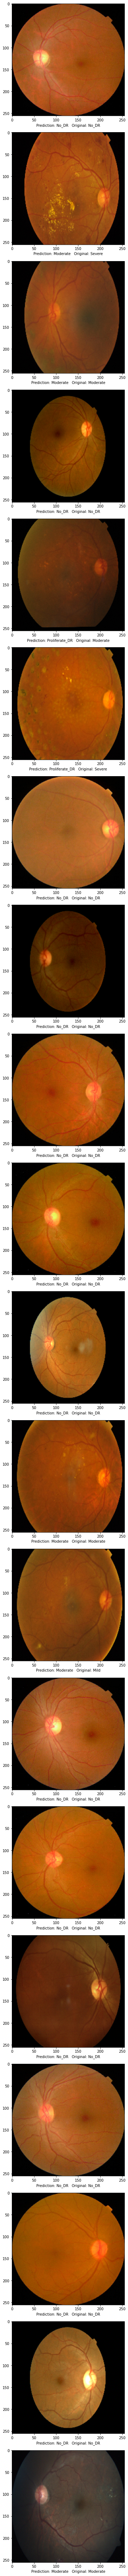

In [50]:
# Visualizing the results
import random
fig=plt.figure(figsize = (100,100))
for i in range(20):
    j = random.randint(0,len(image))
    fig.add_subplot(20, 1, i+1)
    plt.xlabel("Prediction: " + prediction[j] +"   Original: " + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()

In [52]:
# Print out the classification report
print(classification_report(np.asarray(original), np.asarray(prediction)))


                precision    recall  f1-score   support

          Mild       0.66      0.44      0.53        89
      Moderate       0.68      0.81      0.74       201
         No_DR       0.94      0.97      0.96       342
Proliferate_DR       0.57      0.56      0.57        55
        Severe       0.75      0.46      0.57        46

      accuracy                           0.80       733
     macro avg       0.72      0.65      0.67       733
  weighted avg       0.80      0.80      0.79       733



Text(0.5, 1.0, 'Confusion_matrix')

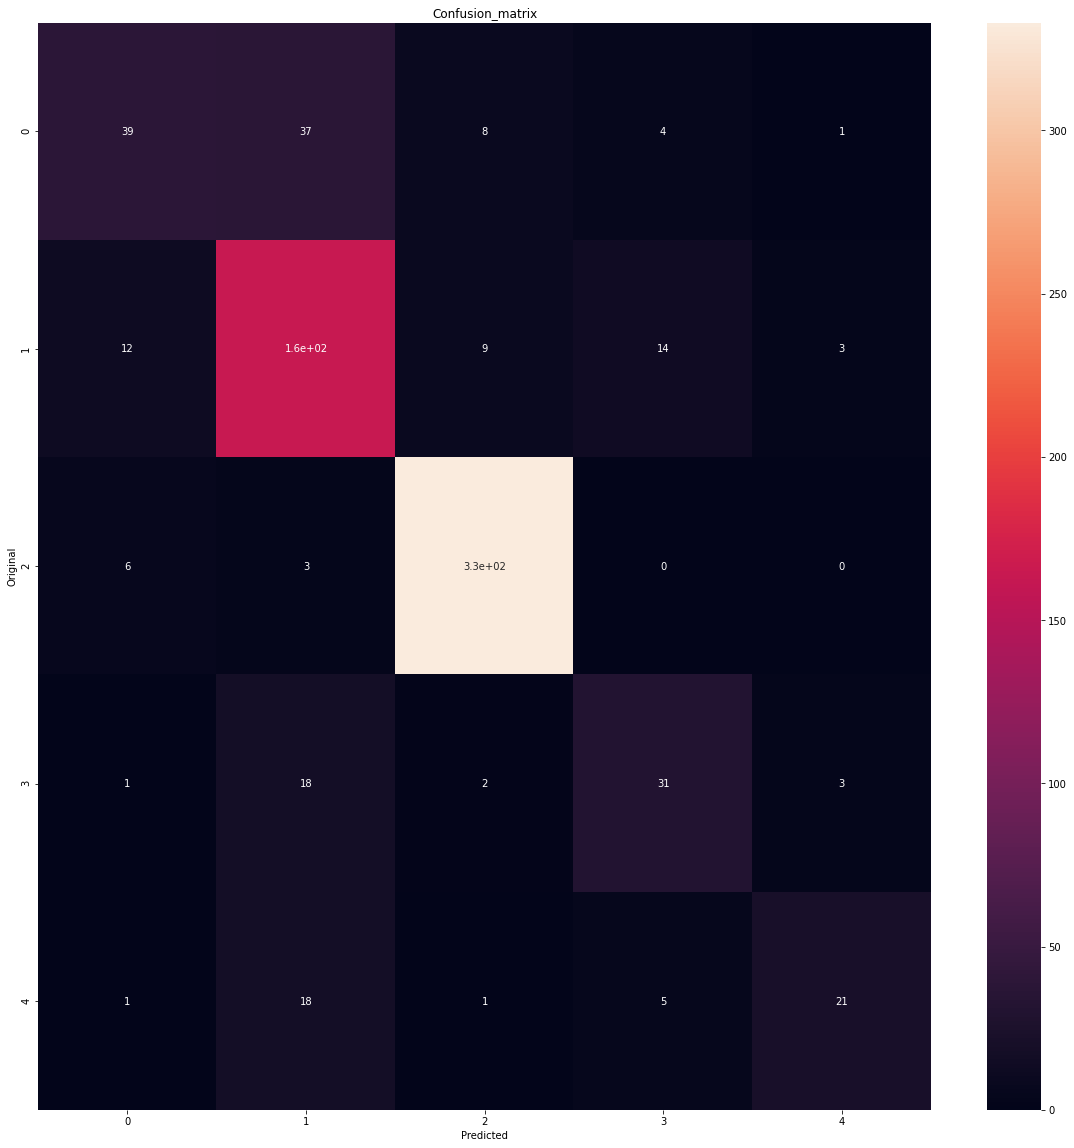

In [53]:
# plot the confusion matrix
plt.figure(figsize = (20,20))
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')


## Summary 

> With more Data and a little bit of tweaks in the Hyper parameters the model could achieve better accuracy on test set.